In [243]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

In [244]:
#model parameters
a, b = 1.0, 2.0 #slope and intercept
#generate noise with mean 0 and standard deviation sigma 3
sigma_0 = 3.0

In [245]:
#experimental data
N_sets = 2000
x = np.linspace(0, 10, 10)

#storing arrays
chi2_vals = np.zeros(N_sets)
all_x = []
all_y = []


In [246]:
#linear fitting function
def lin_model(x, a, b):
    return a * x + b

# the different values for all N_sets stored in lists
all_mean_y = []
all_stdev_y = []
all_parameter_a = []
all_parameter_b = []
all_stdev_a = []
all_stdev_b = []
all_cov = []

#loop over the number of sets
for i in range(N_sets):
    #generate y data with noise
    y = lin_model(x, a, b) + np.random.normal(0, sigma_0, len(x)) #2nd term is the appropriate noise
    
    #store x and y data
    all_x.append(x)
    all_y.append(y)

    # store mean and standard deviation of y
    all_mean_y.append(np.mean(y))
    all_stdev_y.append(np.std(y))
    
     # fit
    popt, pcov = curve_fit(lin_model, x, y,sigma=np.ones_like(x)*sigma_0, absolute_sigma=True)
    y_fit = lin_model(x, *popt)

    # store parameters a and b and their standard deviation and correlation from the fitted covariance matrix
    all_parameter_a.append(popt[0])
    all_parameter_b.append(popt[1])
    all_stdev_a.append(pcov[0][0]**0.5)
    all_stdev_b.append(pcov[1][1]**0.5)
    all_cov.append(pcov[0][1])

    # 4) compute χ² with the variable σ_j
    residuals = y - y_fit
    chi2_vals[i] = np.sum((residuals / sigma_0)**2)

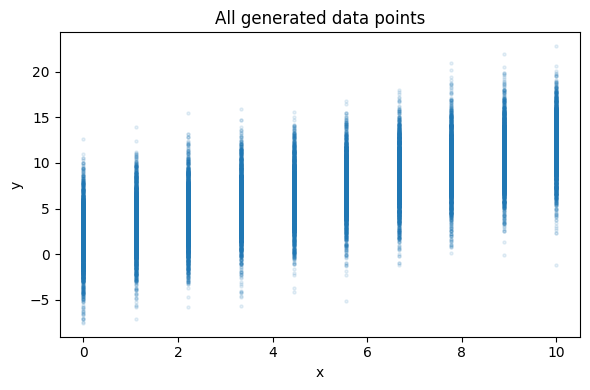

In [247]:
plt.figure(figsize=(6,4))
plt.scatter(all_x, np.concatenate(all_y), s=5, alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('All generated data points')
plt.tight_layout()

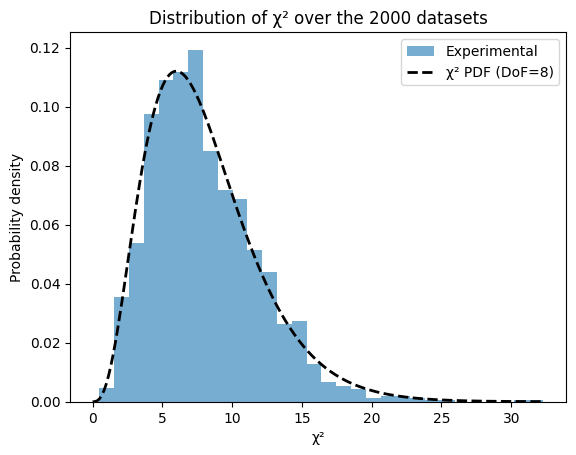

In [248]:
# plt.figure(figsize=(6,4))
counts, bins, _ = plt.hist(chi2_vals, bins=30, density=True, alpha=0.6, label='Experimental')
df = len(x) - 2  # ν = #points – #params = 10–2 = 8
x_pdf = np.linspace(0, np.max(chi2_vals), 200)
plt.plot(x_pdf, chi2.pdf(x_pdf, df), 'k--', lw=2, label=f'χ² PDF (DoF={df})')

plt.xlabel('χ²')
plt.ylabel('Probability density')
plt.title('Distribution of χ² over the {} datasets'.format(N_sets))
plt.legend()
plt.show()

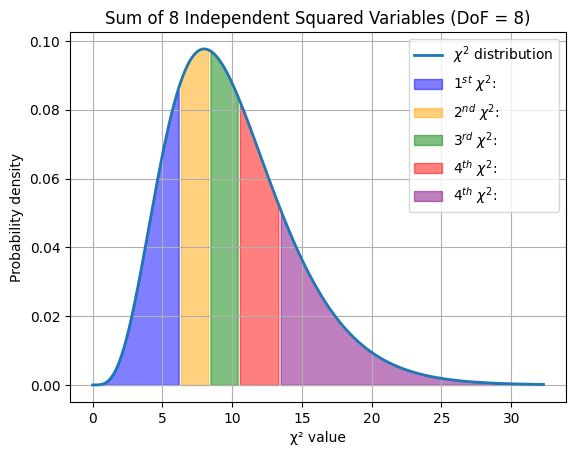

In [249]:
# This uses ppf to find each section (not used)
plt.figure()  # create a new figure
x_pdf = np.linspace(0, np.max(chi2_vals), 200)
plt.plot(x_pdf, chi2.pdf(x_pdf, df=len(x)), linewidth=2, label=r'$\chi^2$ distribution')  # theoretical pdf
quarter = chi2.ppf([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], df=len(x)) # find where each 400 groups starts and ends
section_x_pdf = [] # create a list that stores each section's x_pdf
for i in range(5):
    section_x_pdf.append(x_pdf[(x_pdf >= quarter[i]) & (x_pdf <= quarter[i+1])])
# fill each section with different colors
plt.fill_between(section_x_pdf[0], chi2.pdf(section_x_pdf[0], df=len(x)), where=(section_x_pdf[0] > 0), color='blue', alpha=0.5, label=r'$1^{st}$ $\chi^2$: ')
plt.fill_between(section_x_pdf[1], chi2.pdf(section_x_pdf[1], df=len(x)), where=(section_x_pdf[1] > 0), color='orange', alpha=0.5, label=r'$2^{nd}$ $\chi^2$: ')
plt.fill_between(section_x_pdf[2], chi2.pdf(section_x_pdf[2], df=len(x)), where=(section_x_pdf[2] > 0), color='green', alpha=0.5, label=r'$3^{rd}$ $\chi^2$: ')
plt.fill_between(section_x_pdf[3], chi2.pdf(section_x_pdf[3], df=len(x)), where=(section_x_pdf[3] > 0), color='red', alpha=0.5, label=r'$4^{th}$ $\chi^2$: ')
plt.fill_between(section_x_pdf[4], chi2.pdf(section_x_pdf[4], df=len(x)), where=(section_x_pdf[4] > 0), color='purple', alpha=0.5, label=r'$4^{th}$ $\chi^2$: ')
plt.title(f"Sum of {len(x)-2} Independent Squared Variables (DoF = {len(x)-2})")  # title of the plot
plt.xlabel("χ² value") # x-axis label
plt.ylabel("Probability density") # y-axis label
plt.legend() # show legend in plot
plt.grid(True) # show grid in plot
plt.show() # show plot

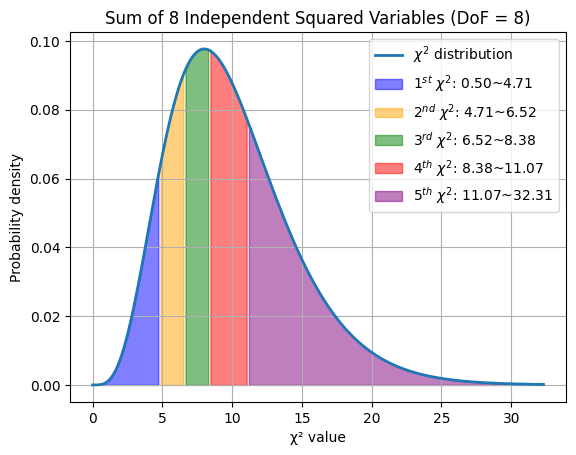

In [250]:
# Sorting the chi-square value and then store each section's parameters a and b
plt.figure()  # create a new figure

# plot the theoretical pdf
x_pdf = np.linspace(0, np.max(chi2_vals), 200)
plt.plot(x_pdf, chi2.pdf(x_pdf, df=len(x)), linewidth=2, label=r'$\chi^2$ distribution')

# set the variables for the sections
section_amount = 5 # amount of sections
color = ['blue', 'orange', 'green', 'red', 'purple'] # each section's color
number_label = [r'$1^{st}$', r'$2^{nd}$', r'$3^{rd}$', r'$4^{th}$', r'$5^{th}$'] # each section's label
section_parameter_a = [[],[],[],[],[]] # each section's parameter a
section_parameter_b = [[],[],[],[],[]] # each section's parameter b
section_x_pdf = [] # each section's x

# combine the chi2_vals, all_parameter_a, and all_parameter_b with zip so sorting one list will link with the other lists
combined = list(zip(chi2_vals, all_parameter_a, all_parameter_b)) # zip
combined.sort(key=lambda a: a[0]) # sort
chi2_vals, all_parameter_a, all_parameter_b = zip(*combined) # unzip

# store the parameters a and b in lists and x of each section's start and end
quarter = [chi2_vals[0]] # the start of the first section's x
k = 0
for i in range(section_amount):
    for j in range(N_sets//section_amount): # 2000/5 = 400
        section_parameter_a[i].append(all_parameter_a[k]) # store parameters a
        section_parameter_b[i].append(all_parameter_b[k])# store parameters b
        k = k + 1
    quarter.append(chi2_vals[k-1]) # x of each section's start and end

# store each section's x (not used later) and fill each section with a different color
for i in range(section_amount):
    section_x_pdf.append(x_pdf[(x_pdf >= quarter[i]) & (x_pdf <= quarter[i+1])]) # store each section's x
    plt.fill_between(section_x_pdf[i], chi2.pdf(section_x_pdf[i], df=len(x)), where=(section_x_pdf[i] > 0), color=color[i], alpha=0.5, label= number_label[i] + r' $\chi^2$: ' + f'{quarter[i]:.2f}~{quarter[i+1]:.2f}') # fill each section with a different color

plt.title(f"Sum of {len(x)-2} Independent Squared Variables (DoF = {len(x)-2})")  # title of the plot
plt.xlabel("χ² value") # x-axis label
plt.ylabel("Probability density") # y-axis label
plt.legend() # show legend in plot
plt.grid(True) # show grid in plot
plt.show() # show plot

Mean of Parameter a in Group 1: 0.9910556909910242
Mean of Parameter b in Group 1: 1.9710055685403147


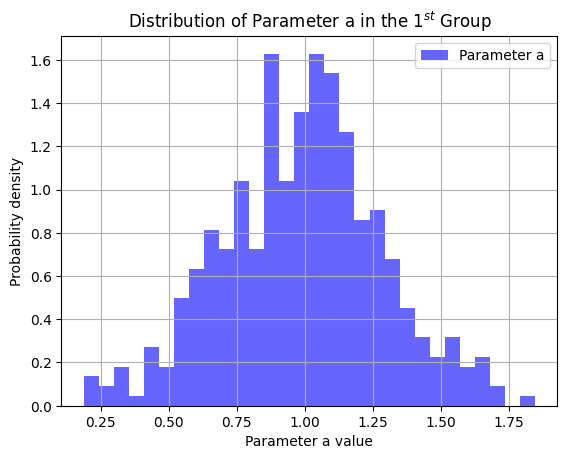

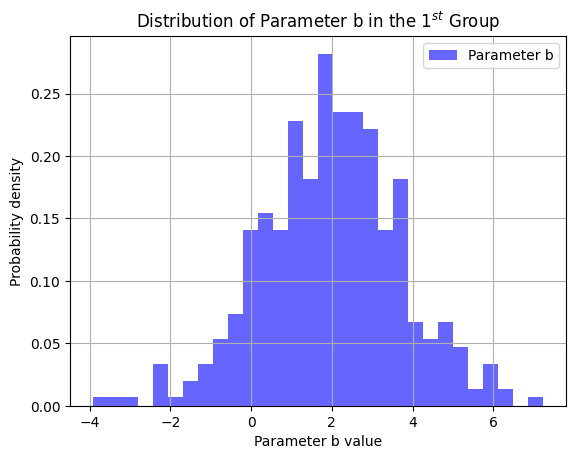

Mean of Parameter a in Group 2: 1.0178413430730655
Mean of Parameter b in Group 2: 1.8793558217262853


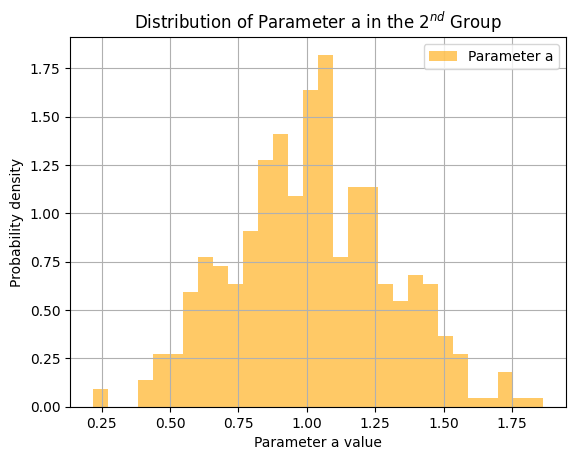

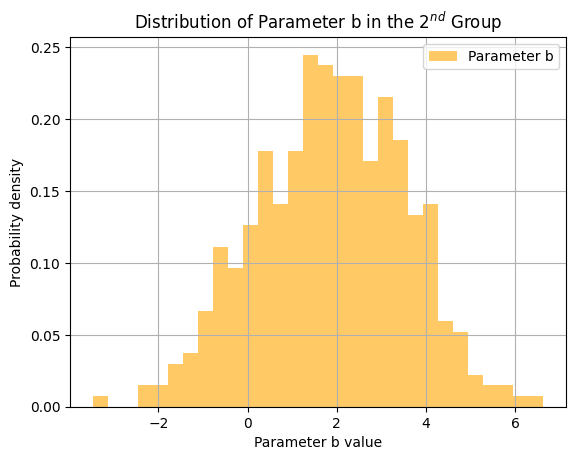

Mean of Parameter a in Group 3: 1.0302396540101904
Mean of Parameter b in Group 3: 1.87339049871111


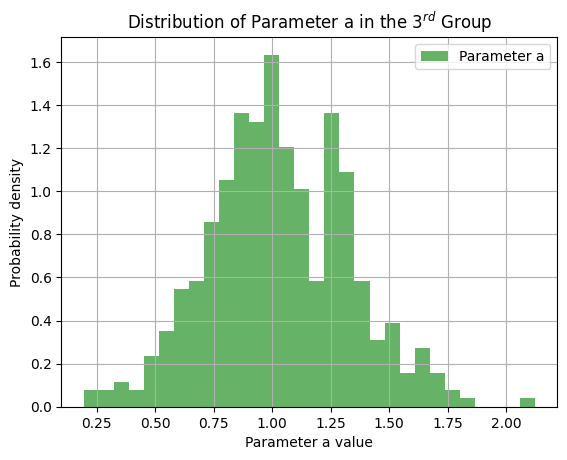

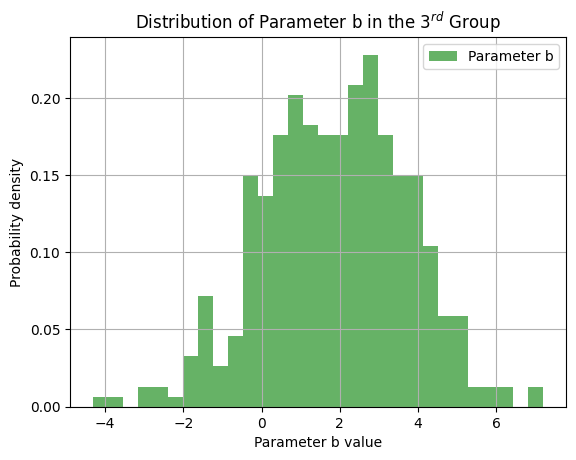

Mean of Parameter a in Group 4: 0.9906060206526203
Mean of Parameter b in Group 4: 1.9974506169187418


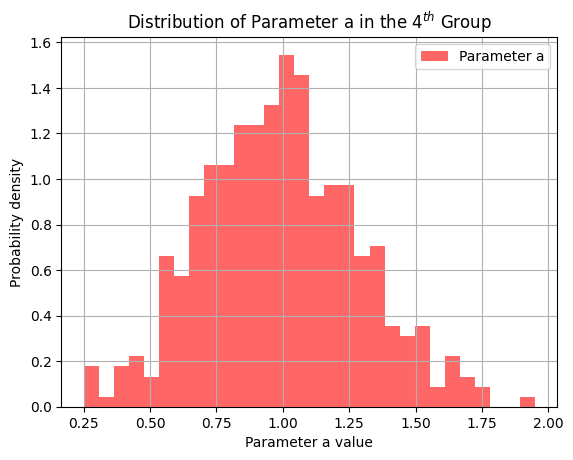

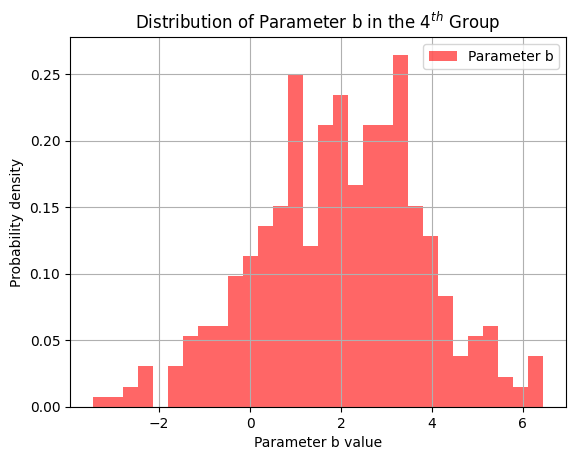

Mean of Parameter a in Group 5: 0.9892977065524385
Mean of Parameter b in Group 5: 2.035310131149263


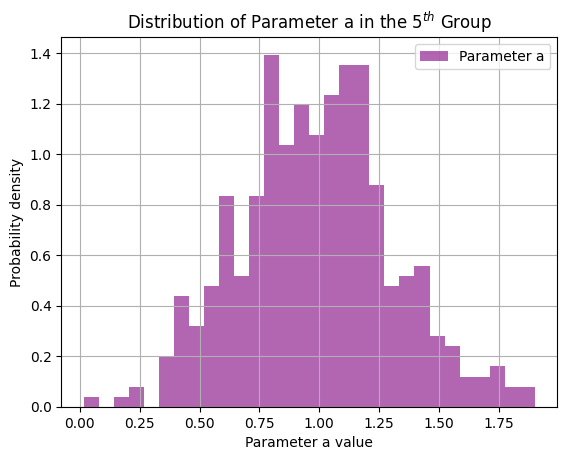

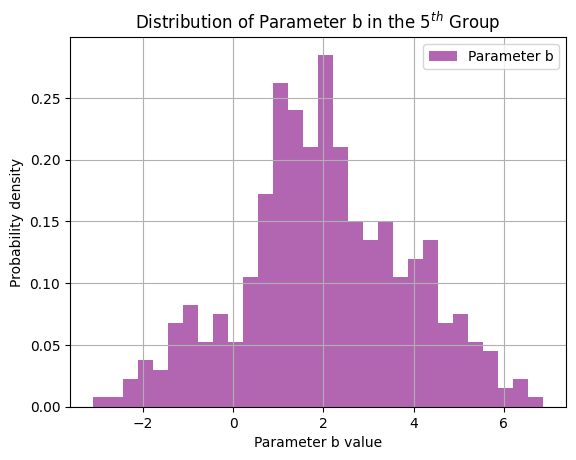

In [251]:
# plot the histogram of parameters a and b for each section
for i in range(section_amount):
    # print the mean of parameters a and b for said section
    print(f"Mean of Parameter a in Group {i+1}:", np.mean(group_parameter_a[i]))
    print(f"Mean of Parameter b in Group {i+1}:", np.mean(group_parameter_b[i]))

    # plot histogram of parameter a for said section
    plt.hist(group_parameter_a[i], bins=30, density=True, alpha=0.6, label='Parameter a', color=color[i])
    plt.title(f"Distribution of Parameter a in the {number_label[i]} Group")  # title of the plot
    plt.xlabel("Parameter a value") # x-axis label
    plt.ylabel("Probability density") # y-axis label
    plt.legend() # show legend in plot
    plt.grid(True) # show grid in plot
    plt.show() # show plot

    # plot histogram of parameter b for said section
    plt.hist(group_parameter_b[i], bins=30, density=True, alpha=0.6, label='Parameter b', color=color[i])
    plt.title(f"Distribution of Parameter b in the {number_label[i]} Group")  # title of the plot
    plt.xlabel("Parameter b value") # x-axis label
    plt.ylabel("Probability density") # y-axis label
    plt.legend() # show legend in plot
    plt.grid(True) # show grid in plot
    plt.show() # show plot

Mean of y: 6.981439506517961
Standard deviation of y: 0.8136986285933151
Calculated from the original data
Mean of Parameter a: 0.985814067932419
Mean of Parameter b: 2.052369168630005
Standard deviation of Parameter a: 0.2932529804763909
Standard deviation of Parameter b: 1.7206018494893767
Correlation of Parameters a and b: -0.8379114459217223
Calculated from the fitted covariance matrix
Standard deviation of Parameter a: 0.297260222190467
Standard deviation of Parameter b: 1.7632614396721074
Correlation of Parameters a and b: -0.4418181932747776


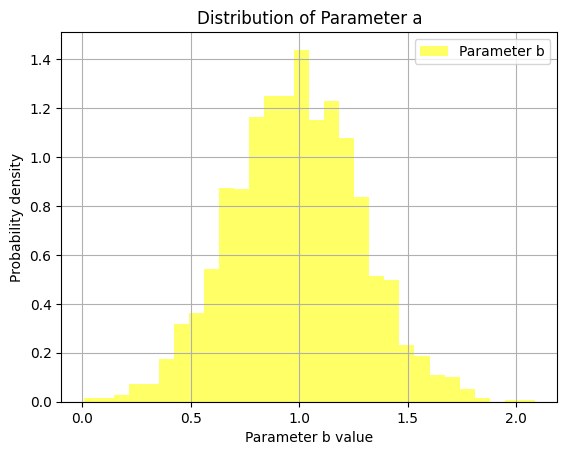

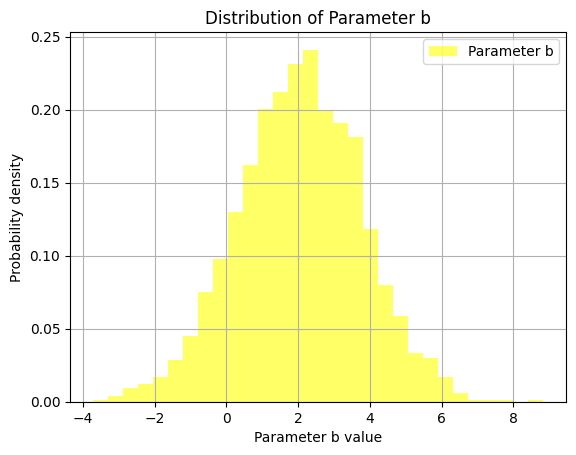

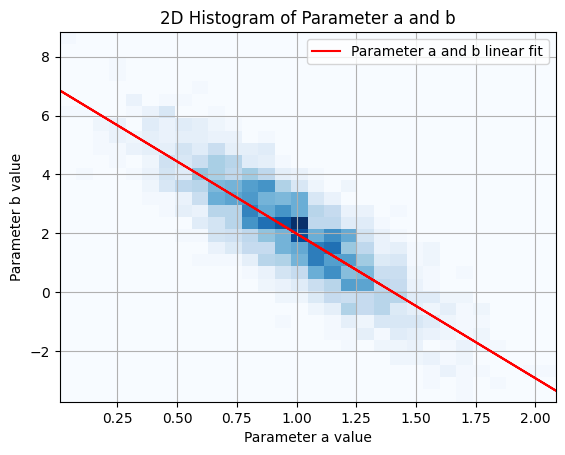

In [252]:
# print values related to y
print("Mean of y:", np.mean(all_mean_y))
print("Standard deviation of y:", np.std(all_stdev_y))

# print values about parameters a and b with different methods
print("=========================================")
print("Calculated from the original data")
print("Mean of Parameter a:", np.mean(all_parameter_a))
print("Mean of Parameter b:", np.mean(all_parameter_b))
print("Standard deviation of Parameter a:", np.std(all_parameter_a))
print("Standard deviation of Parameter b:", np.std(all_parameter_b))
print("Correlation of Parameters a and b:", np.corrcoef(all_parameter_a, all_parameter_b)[0][1])
print("=========================================")
print("Calculated from the fitted covariance matrix")
print("Standard deviation of Parameter a:", np.mean(all_stdev_a))
print("Standard deviation of Parameter b:", np.mean(all_stdev_b))
print("Correlation of Parameters a and b:", np.mean(all_cov))

# plot histogram of parameter a
plt.hist(all_parameter_a, bins=30, density=True, alpha=0.6, label='Parameter b', color='yellow')
plt.title(f"Distribution of Parameter a")  # title of the plot
plt.xlabel("Parameter b value") # x-axis label
plt.ylabel("Probability density") # y-axis label
plt.legend() # show legend in plot
plt.grid(True) # show grid in plot
plt.show() # show plot

# plot histogram of parameter b
plt.hist(all_parameter_b, bins=30, density=True, alpha=0.6, label='Parameter b', color='yellow')
plt.title(f"Distribution of Parameter b")  # title of the plot
plt.xlabel("Parameter b value") # x-axis label
plt.ylabel("Probability density") # y-axis label
plt.legend() # show legend in plot
plt.grid(True) # show grid in plot
plt.show() # show plot

# create a linear fit of parameters a and b for the 2d histogram
popt_ab, pcov_ab = curve_fit(lin_model, all_parameter_a, all_parameter_b) # Here, we call it b = na + m
n, m = popt_ab

# plot 2d histogram of parameters a and b
plt.hist2d(all_parameter_a, all_parameter_b, bins=30, cmap='Blues')
plt.plot(all_parameter_a, np.array(all_parameter_a) * n + m, color='red', label='Parameter a and b linear fit')
plt.title(f"2D Histogram of Parameter a and b")  # title of the plot
plt.xlabel("Parameter a value") # x-axis label
plt.ylabel("Parameter b value") # y-axis label
plt.legend() # show legend in plot
plt.grid(True) # show grid in plot
plt.show() # show plot